In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine
# for getting items with extreme values from dictionaries
from operator import itemgetter
import matplotlib.pyplot as plt

In [2]:
def initialise_tfidf_database(path_to_csv: str):
    # load database file
    # the documents are assumed to have been processed already
    documents_dataframe = pd.read_csv(path_to_csv, sep=';')
    documents_titles = documents_dataframe["Title"]
    documents_contents = documents_dataframe["Content"]

    # prepare tf-idf objects
    # smooth_idf=True: adds 1 to all term occurrences. Prevents dividing by 0
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=True)
    # transform document contents to tf-idf space
    tfidf_data = tfidf_vectorizer.fit_transform(documents_contents).toarray()
    distinct_tfidf_terms = tfidf_vectorizer.get_feature_names_out()
    documents_dataframe_TFIDF = pd.DataFrame(tfidf_data, index = documents_titles, columns = distinct_tfidf_terms)

    return tfidf_vectorizer, documents_dataframe_TFIDF

In [3]:
path_to_lemmatized_data = "./data/articles.csv"
vectorizer, tfidf_database = initialise_tfidf_database(path_to_lemmatized_data)

## Most popular terms

In [4]:
basic_dataframe = pd.read_csv(path_to_lemmatized_data, sep=';')

In [5]:
def create_document_term_matrix(corpus: pd.DataFrame):
    contents = corpus["Content"]
    titles = corpus["Title"]
    count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
    counted_data = count_vectorizer.fit_transform(contents)
    document_term_matrix = pd.DataFrame(counted_data.toarray(), columns=count_vectorizer.get_feature_names_out(), index=titles)
    return document_term_matrix

In [6]:
document_term_matrix = create_document_term_matrix(basic_dataframe)

In [7]:
# should take under 10 seconds
# dictionary structure:
# key: term; value: tuple total occurrences of the term
occurrence_counting_dict = dict()
# key: term; value: number of documents this term appears in
document_counting_dict = dict()
for col in document_term_matrix.columns:
    total_occurrences = sum(document_term_matrix[col])
    different_docs = len(np.where(document_term_matrix[col]>0)[0])
    occurrence_counting_dict[col] = total_occurrences
    document_counting_dict[col] = different_docs

### Terms that occurred the most times

In [8]:
sorted_by_occurrences = sorted(occurrence_counting_dict.items(), key = itemgetter(1), reverse = True)

In [9]:
most_occurrences_to_show = 20
most_occurrences =  dict(sorted_by_occurrences[:most_occurrences_to_show])

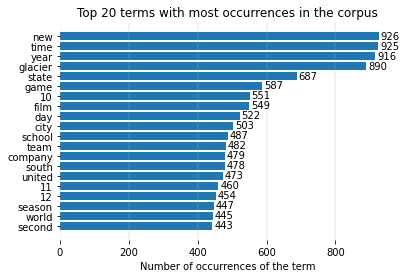

In [10]:
fig, ax = plt.subplots()
ax.grid(axis='x', linewidth=0.3)
ax.barh(list(most_occurrences.keys()), most_occurrences.values())
for i, value in enumerate(most_occurrences.values()):
    # this does not change the value the '+' simply moves the text n units to the right
    ax.text(value+5, i + .25, str(value))
# remove the box surrouding the plot
for position in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[position].set_visible(False)
ax.invert_yaxis()
ax.set_title(f"Top {most_occurrences_to_show} terms with most occurrences in the corpus")
ax.set_xlabel("Number of occurrences of the term")
plt.show()

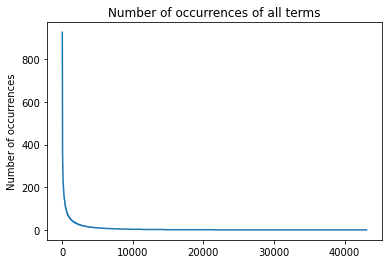

In [11]:
plt.plot(range(len(sorted_by_occurrences)), np.array(sorted_by_occurrences)[:, 1].astype('int'))
plt.title("Number of occurrences of all terms")
plt.ylabel("Number of occurrences")
plt.show()

### Terms that occurred in the largest number of documetns

In [12]:
sorted_by_doc_count = sorted(document_counting_dict.items(), key = itemgetter(1), reverse = True)

In [13]:
most_doc_appearances_to_show = 20
most_documents =  dict(sorted_by_doc_count[:most_doc_appearances_to_show])

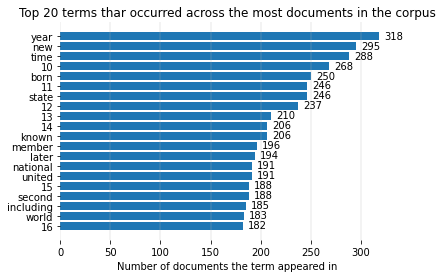

In [14]:
fig, ax = plt.subplots()
ax.grid(axis='x', linewidth=0.3)
ax.barh(list(most_documents.keys()), most_documents.values())
for i, value in enumerate(most_documents.values()):
    # this does not change the value the '+' simply moves the text n units to the right
    ax.text(value+5, i + .25, str(value))
# remove the box surrouding the plot
for position in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[position].set_visible(False)
ax.invert_yaxis()
ax.set_title(f"Top {most_doc_appearances_to_show} terms thar occurred across the most documents in the corpus")
ax.set_xlabel("Number of documents the term appeared in")
plt.show()

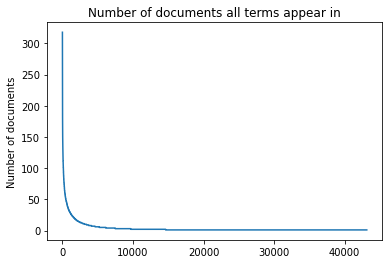

In [15]:
plt.plot(range(len(sorted_by_doc_count)), np.array(sorted_by_doc_count)[:, 1].astype('int'))
plt.title("Number of documents all terms appear in")
plt.ylabel("Number of documents")
plt.show()

## Top similarities

In [16]:
# Long computation! 2minutes+
similarity_dict = dict()
for i in range(len(tfidf_database)-1):
    for j in range(i+1, len(tfidf_database)):
        name_i = tfidf_database.iloc[i].name
        name_j = tfidf_database.iloc[j].name
        cosine_sim = 1 - cosine(tfidf_database.iloc[i], tfidf_database.iloc[j])
        if cosine_sim > 0.1:
            similarity_dict[(name_i, name_j)] = cosine_sim

In [17]:
top_pairs_to_show = 20
top_similarities =  dict(sorted(similarity_dict.items(), key = itemgetter(1), reverse = True)[:top_pairs_to_show])

In [18]:
for key in top_similarities.keys():
    print(key, top_similarities[key])

('Electoral results for the district of Hinchinbrook', 'Electoral results for the district of Chatsworth') 0.8030239113723475
('Lumber City, Georgia', 'Michigan City, North Dakota') 0.6762300315207807
('Michigan City, North Dakota', 'Springfield, Jackson County, Wisconsin') 0.6741228158998228
('Enfield, Illinois', 'Springfield, Jackson County, Wisconsin') 0.6667915015522147
('2024 United States presidential election in Maine', '1924 United States Senate election in Montana') 0.6537564076583925
('Lumber City, Georgia', 'Springfield, Jackson County, Wisconsin') 0.6533870214122245
('List of Acts of the National Assembly for Wales from 2019', 'List of RPM number-one country singles of 1965') 0.6325268754429131
('Michigan City, North Dakota', 'Enfield, Illinois') 0.6045125494491133
('Lumber City, Georgia', 'Enfield, Illinois') 0.5959779687191985
('Mound Station, Illinois', 'Springfield, Jackson County, Wisconsin') 0.5796618704099051
('Mound Station, Illinois', 'Enfield, Illinois') 0.5773832

In [19]:
# looking for some other interesting similarities
dict(sorted(similarity_dict.items(), key = itemgetter(1), reverse = True)[150:170])

{('Special Achievement Genie',
  'List of Acts of the National Assembly for Wales from 2019'): 0.2708404788174399,
 ('Romang (island)', 'Saattorsuaq Island'): 0.27001903213765654,
 ('J Rabbit', 'Kelly Lee Owens'): 0.2696304616645542,
 ('2011 South American Rugby Championship "B"',
  'Felix Latzke'): 0.268769772140933,
 ('Jonathan Anders', 'Richard Waite (cricketer)'): 0.2680940536074491,
 ('Alexeyevskoye, Vladimir Oblast', 'Posyolok Ilyicha'): 0.2680780279066992,
 ('E. B. Eddy Company', 'List of mayors in Canada'): 0.2679142242950099,
 ('Tribhuvan University Central Library',
  'National Library of Mozambique'): 0.2672642329714363,
 ('Catherine Brown (footballer)',
  'George Edwards (Australian footballer)'): 0.26715179352469054,
 ('Eupithecia palpata', 'List of mayors in Canada'): 0.26651069819792395,
 ('1979 VFL Grand Final',
  'List of RPM number-one country singles of 1965'): 0.2662953950558904,
 ('List of highways numbered 32', 'Wisconsin Highway 175'): 0.2658813030028695,
 ('Śpig

In [20]:
# least similar terms, just for fun
dict(sorted(similarity_dict.items(), key = itemgetter(1), reverse = True)[-20:])

{("The Folks from Mother's Mixer",
  'Oak Mountain 2001 - Night 1'): 0.10022082795812859,
 ('Special Achievement Genie', 'Ellen Ripley'): 0.10021769066841224,
 ('List of Acts of the National Assembly for Wales from 2019',
  'Kendra Norman-Bellamy'): 0.10021196278528532,
 ("H'El on Earth", 'George Klein (comics)'): 0.1002053457554608,
 ('Geneva Commons', 'Enfield, Illinois'): 0.10019641423505332,
 ('Kodiya', 'Enfield, Illinois'): 0.10019040724914918,
 ('Jing Chunhua', 'John Sola'): 0.10018027214699377,
 ('John McMillan (economist)',
  'Ronald Brown (mathematician)'): 0.10017663349003769,
 ('Gavin Main', 'Rose Lavelle'): 0.10012495863069659,
 ('Climate of the United Kingdom',
  'Central Karakoram National Park'): 0.10011606179450683,
 ('Terry Orr', 'Crystal Palace F.C.'): 0.10011380243022838,
 ('1977–78 Tongan A Grade', '2015–16 Scarlets season'): 0.10010580782794554,
 ('Pat Saward', '2011–12 Sunderland A.F.C. season'): 0.10009661870213993,
 ('Electoral results for the district of Hinchi